Populating the interactive namespace from numpy and matplotlib

test pour sufficient_statistics(data,dico,0,1,[2,3])
(16.355207462350094, 3)

test pour indep_score(data, dico, 1, 7, [] )
1.12562784979e-10

 test pour best_candidate(data, dico, 0, [], 0.05 )
[]

 test pour create_parents(data, dico, 6, 0.05 )
[4, 5]
[]
BN{nodes: 8, arcs: 8, domainSize: 256, parameters: 38, compression ratio: 85% }


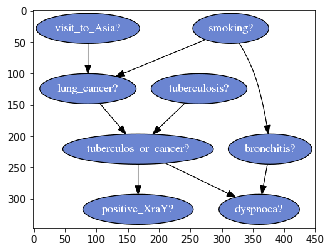

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct 24 12:45:17 2017

@author: 3410370 
"""

%pylab inline

import numpy as np
import math
import scipy.stats as stats
import pydotplus
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pyAgrum as gum
import pyAgrum.lib.ipython as gnb
import pyAgrum.lib.notebook as gnb

"""
----------------------------------------LECTURE DES DONNÉES------------------------------------
"""

# fonction pour transformer les données brutes en nombres de 0 à n-1
def translate_data ( data ):
    # création des structures de données à retourner
    nb_variables = data.shape[0]
    nb_observations = data.shape[1] - 1 # - nom variable
    res_data = np.zeros ( (nb_variables, nb_observations ), int )
    res_dico = np.empty ( nb_variables, dtype=object )

    # pour chaque variable, faire la traduction
    for i in range ( nb_variables ):
        res_dico[i] = {}
        index = 0
        for j in range ( 1, nb_observations + 1 ):
            # si l'observation n'existe pas dans le dictionnaire, la rajouter
            if data[i,j] not in res_dico[i]:
                res_dico[i].update ( { data[i,j] : index } )
                index += 1
            # rajouter la traduction dans le tableau de données à retourner
            res_data[i,j-1] = res_dico[i][data[i,j]]
    return ( res_data, res_dico )


# fonction pour lire les données de la base d'apprentissage
def read_csv ( filename ):
    data = np.loadtxt ( filename, delimiter=',', dtype=np.str ).T
    names = data[:,0].copy ()
    data, dico = translate_data ( data )
    return names, data, dico

# names : tableau contenant les noms des variables aléatoires
# data  : tableau 2D contenant les instanciations des variables aléatoires
# dico  : tableau de dictionnaires contenant la correspondance (valeur de variable -> nombre)
names, data, dico = read_csv ( "2015_tme5_asia.csv" )    


"""
----------------------------------------------STATISTIQUE DU X² CONDITIONNELLE--------------- 
"""

# etant donné une BD data et son dictionnaire, cette fonction crée le
# tableau de contingence de (x,y) | z
def create_contingency_table ( data, dico, x, y, z ):
    # détermination de la taille de z
    size_z = 1
    offset_z = np.zeros ( len ( z ) )
    j = 0
    for i in z:
        offset_z[j] = size_z       
        size_z *= len ( dico[i] )
        j += 1

    # création du tableau de contingence
    res = np.zeros ( size_z, dtype = object )

    # remplissage du tableau de contingence
    if size_z != 1:
        z_values = np.apply_along_axis ( lambda val_z : val_z.dot ( offset_z ),
                                         1, data[z,:].T )
        i = 0
        while i < size_z:
            indices, = np.where ( z_values == i )
            a,b,c = np.histogram2d ( data[x,indices], data[y,indices], 
                                     bins = [ len ( dico[x] ), len (dico[y] ) ] )
            res[i] = ( indices.size, a )
            i += 1
    else:
        a,b,c = np.histogram2d ( data[x,:], data[y,:], 
                                 bins = [ len ( dico[x] ), len (dico[y] ) ] )
        res[0] = ( data.shape[1], a )
    return res
    
"""   
--------------------------------------------------STATISTIQUE DU X² DE DEGRE DE LIBERTE-------------------
"""

def sufficient_statistics(data, dico, x, y, z ):
    
    res=create_contingency_table(data,dico,x, y, z)
    res_X=0
    z=0
    for i in range(len(res)):
        if(res[i][0]!=0):
            z+=1
    for i in range(len(dico[x])):
        for j in range(len(dico[y])):
            for k in range(len(res)):
                N_z=res[k][0]
                if(N_z!=0):
                    N_xyz=res[k][1]
                    N_xz=np.sum(res[k][1],1)
                    N_yz=np.sum(res[k][1],0)
                    frac=(N_xz[i]*N_yz[j])/N_z
                    if(frac!=0):
                        res_X+=math.pow(N_xyz[i][j]-frac,2)/frac

                    
    return (res_X,(len(dico[x])-1)*(len(dico[y])-1)*z)
                

test1=sufficient_statistics(data,dico,0,1,[2,3])
print("\ntest pour sufficient_statistics(data,dico,0,1,[2,3])")
print(test1)
    
    
"""   
--------------------------------------------------TEST D'INDEPENDANCE----------------------------
"""

def indep_score(data, dico, x, y, z ):
    res=create_contingency_table(data,dico,x, y, z)
    d_min=5*len(dico[x])*len(dico[y])*len(res)  
    if(len(data[0])>=d_min):
        res=sufficient_statistics(data, dico, x, y, z )
        return res
    else:
        return (-1,1)
        
test2=indep_score(data, dico, 1, 7, [] )
test2=stats.chi2.sf(test2[0],test2[1])
print("\ntest pour indep_score(data, dico, 1, 7, [] )")
print(test2)
    
 
"""   
-------------------------------------------------MEILLEUR CANDIDAT POUR ETRE UN PARENT------------
"""

def best_candidate(data, dico, x, z, alpha ):
    list_x_y=[]

    for y in range(0,x):
        res=indep_score(data, dico, x, y, z )
        list_x_y.append(stats.chi2.sf(res[0],res[1]))
    min_x=min(list_x_y)
    if(min_x< alpha):
        return [list_x_y.index(min_x)]
    else:
        return []

test3=best_candidate(data, dico, 1, [], 0.05 )
print("\n test pour best_candidate(data, dico, 0, [], 0.05 )")
print(test3)



    
"""
----------------------------------------------CREATION DES PARENTS D'UN NOEUD-----------------------
"""

def create_parents(data, dico, x, alpha ):
    z=[]
    res=best_candidate(data,dico,x,z,alpha)
    while(res!=[]):
        z.append(res[0])
        res=best_candidate(data,dico,x,z,alpha)
    return z

test4=create_parents(data, dico, 6, 0.05 )
print("\n test pour create_parents(data, dico, 6, 0.05 )")
print(test4)  
  
 
print(create_parents(data,dico,1,0.05))

"""
------------------------------------------------APPRENTISSAGE DE LA STRUCTURE D'UN RESEAU BAYESIEN-----------
"""

def learn_BN_structure(data,dico,alpha):
    res=[[]]
    for i in range(1,len(data)):
        a=create_parents(data, dico, i, alpha )
        res.append(a)
    #print(res)
    return np.array(res)
        
test5=learn_BN_structure(data,dico,0.05)



style = { "bgcolor" : "#6b85d1", "fgcolor" : "#FFFFFF" }

def display_BN ( node_names, bn_struct, bn_name, style ):
    graph = pydotplus.Dot( bn_name, graph_type='digraph')

    # création des noeuds du réseau
    for name in node_names:
        new_node = pydotplus.Node( name, 
                               style="filled",
                               fillcolor=style["bgcolor"],
                               fontcolor=style["fgcolor"] )
        graph.add_node( new_node )

    # création des arcs
    for node in range ( len ( node_names ) ):
        parents = bn_struct[node]
        for par in parents:
            new_edge = pydotplus.Edge ( node_names[par], node_names[node] )
            graph.add_edge ( new_edge )

    # sauvegarde et affaichage
    outfile = bn_name + '.png'
    graph.write_png( outfile )
    img = mpimg.imread ( outfile )
    plt.imshow( img )
    
    
display_BN(names,test5,"reseau_asia",style)
    

"""------------------------------------------------------FIN DE L'APPRENTISSAGE ET CALCUL PROBALISTE-------------------
"""



def learn_parameters ( bn_struct, ficname ):
    # création du dag correspondant au bn_struct
    graphe = gum.DAG ()
    nodes = [ graphe.addNode () for i in range ( bn_struct.shape[0] ) ]
    for i in range ( bn_struct.shape[0] ):
        for parent in bn_struct[i]:
            graphe.addArc ( nodes[parent], nodes[i] )

    # appel au BNLearner pour apprendre les paramètres
    learner = gum.BNLearner ( ficname )
    learner.useScoreLog2Likelihood ()
    learner.useAprioriSmoothing ()
    return learner.learnParameters ( graphe )

# création du réseau bayésien à la aGrUM
bn = learn_parameters ( test5, "2015_tme5_asia.csv" )

# affichage de sa taille
print(bn)
    

# récupération de la ''conditional probability table'' (CPT) et affichage de cette table
gnb.showPotential( bn.cpt ( bn.idFromName ( 'bronchitis?' ) ) )

# calcul de la marginale
proba = gum.getPosterior ( bn, {}, 'bronchitis?' )

# affichage de la marginale
gnb.showPotential( proba )
gnb.showPotential(gum.getPosterior ( bn,{'smoking?': 'true', 'tuberculosis?' : 'false' }, 'bronchitis?' ))
















